
# TorchRLとRL4COによる強化学習

> 強化学習パッケージ TorchRLの基本的な使用法を紹介し， それを利用した強化学習による組合せ最適化パッケージ RL4CO で巡回セールスマン問題を解く．

## TorchRLによる強化学習の基礎

In [ ]:
import torch
from tensordict.nn import TensorDictModule

import gymnasium as gym
from torchrl.envs.libs.gym import GymEnv, GymWrapper

### 振り子の環境を準備

[Pendulum-v1](https://gymnasium.farama.org/environments/classic_control/pendulum/)

- 観測 observation: $x,y,\theta$
- 行動 action: トルク（回転力）

環境 env を生成し，環境をリセットする． 以下の観測値を含むフィールドをもつ初期状態を表すテンソル辞書が得られる．

- done: 
- observation: 観測値
- terminated: 
- truncated: 

In [ ]:
gym_env = gym.make("Pendulum-v1")
env = GymWrapper(gym_env, device="cpu")

reset = env.reset()
print(reset)

TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([3]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)


### 行動

リセットに次いでランダムな行動を rand_action で得る．

これもテンソル辞書で，行動 action のフィールドが追加されている．

In [ ]:
reset_with_action = env.rand_action(reset)
print(reset_with_action)

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([3]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)


In [ ]:
print(reset_with_action["observation"], reset_with_action["action"])

tensor([ 0.5448, -0.8386,  0.8938]) tensor([0.0090])


### ステップ

行動をstepに入れて次のステップに進む． 返値のテンソル辞書には， nextのフィールドが追加されている． nextには次に移る状態を表すテンソル辞書が格納されている．

In [ ]:
stepped_data = env.step(reset_with_action)
print(stepped_data)

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([3]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([]),
            device=cpu,
            is_shared=False),
        observation: Tensor(shape=torch.Size([3]), device=cpu, dtype=torch.float32, is_shared=False),
        terminate

In [ ]:
print(stepped_data["action"], stepped_data["next"])

tensor([0.4661]) TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([3]), device=cpu, dtype=torch.float32, is_shared=False),
        reward: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)


### マルコフ決定過程

行動をステップに入れたものをstep_mdp関数に入れると次の状態に移る． nextが複数ある場合には，マルコフ決定過程 (MDP: Markov Decision Process)にしたがい，次の状態が選択される．

In [ ]:
from torchrl.envs import step_mdp

data = step_mdp(stepped_data)
print(data)

TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([3]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)


### ロールアウト

rolloutを用いると，上の一連の操作を連続で行うことができる． max_stepsの反復の情報を保管したテンソル辞書が返される．


In [ ]:
rollout = env.rollout(max_steps=10)
print(rollout, "\n", rollout["observation"])

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([10, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([10]),
            device=cpu,
            is_shared=False),
        observation: Tensor(shape=torch.Size([10, 3]), device=cpu, dtype=torch.float32, i

### 方策

簡単な1層の線形層をテンソル辞書を用いて生成し， ロールアウトを行う．

In [ ]:
from tensordict.nn import TensorDictModule

module = torch.nn.LazyLinear(out_features=env.action_spec.shape[-1])
policy = TensorDictModule(
    module,
    in_keys=["observation"],
    out_keys=["action"],
)

In [ ]:
rollout = env.rollout(max_steps=10, policy=policy)
print(rollout)

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([10, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([10, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([10]),
            device=cpu,
            is_shared=False),
        observation: Tensor(shape=torch.Size([10, 3]), device=cpu, dtype=torch.float32, i

## RL4COによる強化学習で組合せ最適化問題の求解

巡回セールスマン問題の環境 TSPEnvを準備する．　点数は $50$ の問題例を生成する．

方策はトランスフォーマーを用いる．これはエンコーダーとデコーダーから構成される．

訓練には REINFORCE を用いる．

In [ ]:
import torch

from rl4co.envs import TSPEnv
from rl4co.models import AttentionModelPolicy, REINFORCE
from rl4co.utils.trainer import RL4COTrainer

In [ ]:
# RL4CO env based on TorchRL
env = TSPEnv(generator_params={'num_loc': 50})

# Policy: neural network, in this case with encoder-decoder architecture
policy = AttentionModelPolicy(env_name=env.name,
                              embed_dim=128,
                              num_encoder_layers=3,
                              num_heads=8,
                            )

# RL Model: REINFORCE and greedy rollout baseline
model = REINFORCE(env,
                    policy,
                    baseline="rollout",
                    batch_size=512,
                    train_data_size=100_000,
                    val_data_size=10_000,
                    optimizer_kwargs={"lr": 1e-4},
                    )

/Users/mikiokubo/miniconda3/envs/jupyterlab/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/Users/mikiokubo/miniconda3/envs/jupyterlab/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


### 訓練していない方策でロールアウト

Problem 1 | Cost: 28.789
Problem 2 | Cost: 21.648
Problem 3 | Cost: 23.582


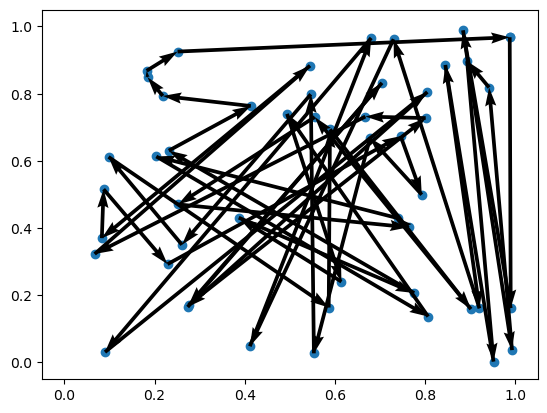

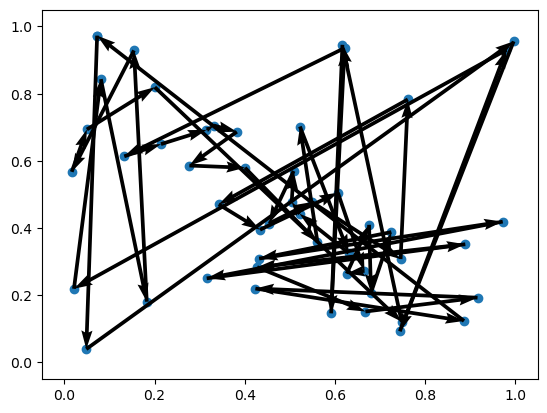

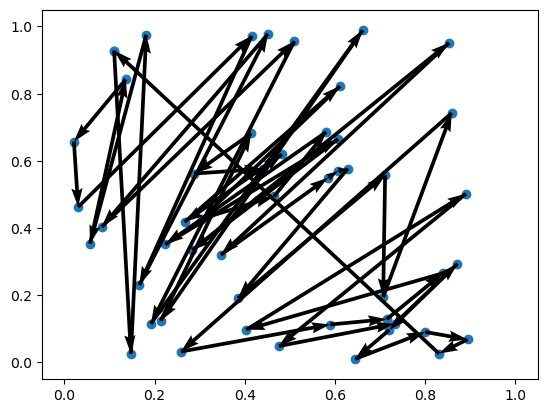

In [ ]:
# Greedy rollouts over untrained policy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
policy = policy.to(device)
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])


### 訓練クラスの生成

RL4COTrainerクラスのインスタンスを準備し， エポック数 $3$ で訓練を行う．

In [ ]:
trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=1,
    logger=None,
)

Using 16bit Automatic Mixed Precision (AMP)
/Users/mikiokubo/miniconda3/envs/jupyterlab/lib/python3.10/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikiokubo/miniconda3/envs/jupyterlab/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [ ]:
trainer.fit(model)

val_file not set. Generating dataset instead
test_file not set. Generating dataset instead

  | Name     | Type                 | Params | Mode 
----------------------------------------------------------
0 | env      | TSPEnv               | 0      | train
1 | policy   | AttentionModelPolicy | 710 K  | train
2 | baseline | WarmupBaseline       | 710 K  | train
----------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.681     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|                                                                               | 0/2 [00:00<?, ?it/s]

/Users/mikiokubo/miniconda3/envs/jupyterlab/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/mikiokubo/miniconda3/envs/jupyterlab/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


/Users/mikiokubo/miniconda3/envs/jupyterlab/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|███████████████████████████████████████| 196/196 [12:31<00:00,  0.26it/s, v_num=59, train/reward=-7.30, train/loss=-0.694]
Validation: |                                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████████████████| 196/196 [12:19<00:00,  0.27it/s, v_num=59, train/reward=-6.72, train/loss=-1.64, val/reward=-6.63]
Validation: |                                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████████| 196/196 [12:15<00:00,  0.27it/s, v_num=59, train/reward=-6.60, train/loss=-3.36, val/reward=-6.46]
Validation: |                                                                                                     | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████████| 196/196 [13:01<00:00,  0.25it/s, v_num=59, train/reward=-6.60, train/loss=-3.36, val/reward=-6.40]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████████████████| 196/196 [14:34<00:00,  0.22it/s, v_num=59, train/reward=-6.60, train/loss=-3.36, val/reward=-6.40]


### 最適化

訓練した方策で求解し，可視化する．

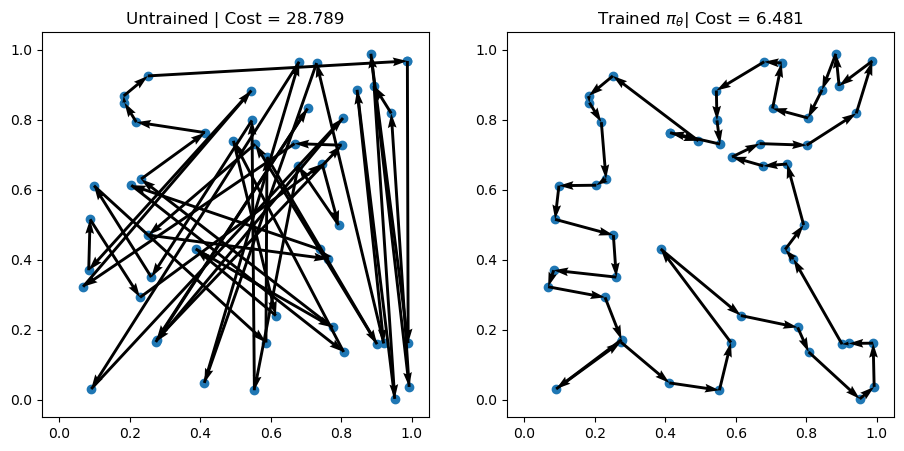

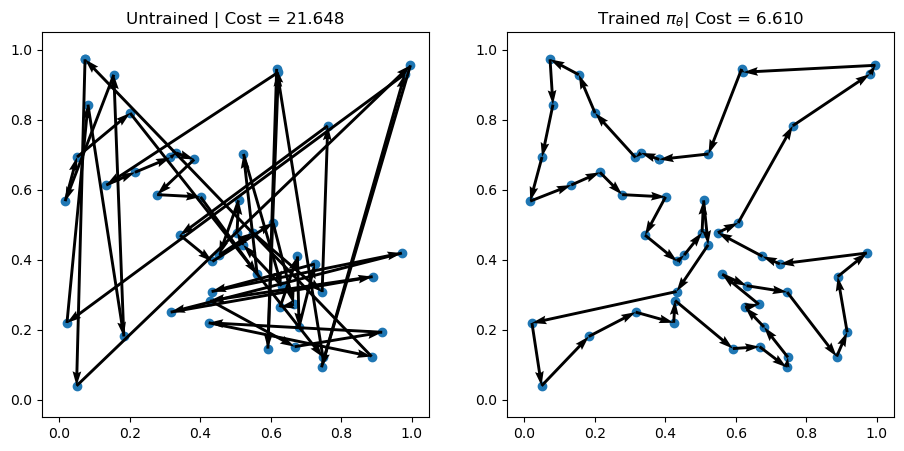

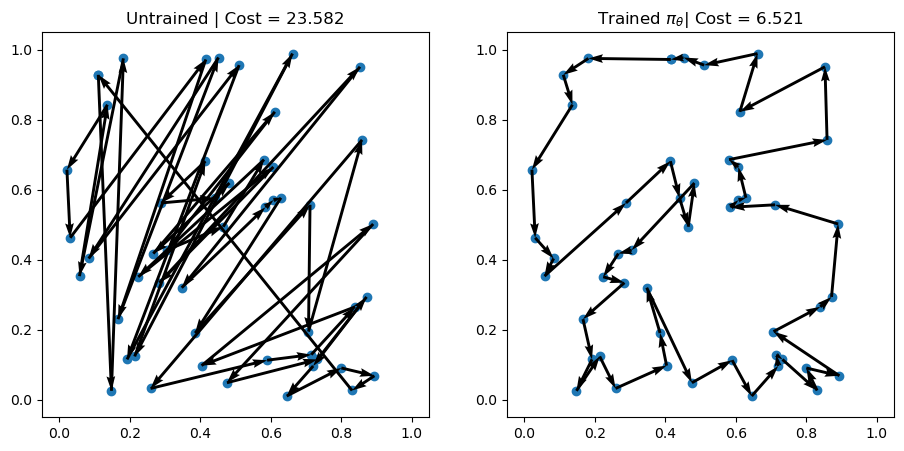

In [ ]:
# Greedy rollouts over trained model (same states as previous plot)
policy = model.policy.to(device)
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0])
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")